# Gravitational Orbits in Cartesian Coordinates

Uses the Orbit class to generate orbit plots in Cartesian coordinates. The Orbit class solves the equations of motion for two particles orbiting each other due to gravitational attraction

* Last Revision 4/28/2023 by Jessy Wu

## Set-Up and Equations of Motions

We begin by constructing the Langrangian of the two body system. 

$\begin{align}
\mathcal{L} = \frac 12 m_1 \mathbf{\dot r}_1^2 + \frac 12 m_2 \mathbf{\dot r}_2^2 - U(|\mathbf{r}|) 
\end{align}$ 

Where,
$\begin{align}
U(|\mathbf{r}|) = - \frac {G m_1 m_2} {|\mathbf{r}_1 - \mathbf{r}_2|} 
\end{align}$

We apply the standard procedure:

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot r_i} - \frac{\partial\mathcal L}{\partial r_i} = 0
\end{align}$

And obtain the following:

$\begin{align}
m_1 \mathbf{\ddot r}_1 = - G m_1 m_2 \frac{ (\mathbf{r}_1 - \mathbf{r}_2) } { |\mathbf{r}_1 - \mathbf{r}_2|^3 }
\end{align}$

$\begin{align}
m_2 \mathbf{\ddot r}_2 = - G m_1 m_2 \frac{ (\mathbf{r}_2 - \mathbf{r}_1) } { |\mathbf{r}_1 - \mathbf{r}_2|^3 }
\end{align}$

The conservation of angular momentum allows us to confine the orbit to a single plane, that being the x-y plane. 

Decomposing the vector equations above, we get the following: 

$\begin{align}
m_1 \ddot x_1 = G m_1 m_2 \frac{ (x_2 - x_1) } { |\mathbf{r}_1 - \mathbf{r}_2|^3 }\\ \\
m_1 \ddot y_1 = G m_1 m_2 \frac{ (y_2 - y_1) } { |\mathbf{r}_1 - \mathbf{r}_2|^3 }\\ \\
m_2 \ddot x_2 = - G m_1 m_2 \frac{ (x_2 - x_1) } { |\mathbf{r}_1 - \mathbf{r}_2|^3 }\\ \\
m_2 \ddot y_2 = - G m_1 m_2 \frac{ (y_2 - y_1 ) } { |\mathbf{r}_1 - \mathbf{r}_2|^3 }
\end{align}$

Where, 

$\begin{align}
|\mathbf{r}_1 - \mathbf{r}_2| = ((x_1 - x_2)^2+(y_1 - y_2)^2)^\frac 12
\end{align}$



In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

## Orbit class 

In [4]:
class Orbit():
    """
    The Orbit class implements the parameters and Lagrange's equations for two orbiting 
    particles. We will be using two algorithms  for solving the differential equations. 
    These would be the Runge-Kutta 2nd order algorithm and the Leapfrog method. The Leapfrog
    method is time-reversal invariant and conserves energy. 
     
    Parameters
    ----------
    G : float
        Universal gravitational constant
    m1 : float
        mass of first particle
    m2 : float
        mass of second particle

    Methods
    -------
    dq_dt(t, q)
        Returns the right side of the differential equation in vector q, 
        given time t and the corresponding value of q.
    """
    def __init__(self, m_1=1., m_2=1., G=1.):
        self.m_1 = m_1
        self.m_2 = m_2
        self.G = G
    
    def dq_dt(self, t, q):
        """
        This function returns the right-hand side of the diffeq in the vector q. 
        [dq/dt d^2q/dt^2]
    
        Parameters
        ----------
        t : float
            time 
        q : float
            An 8-component vector with 
            q[0] = x_1(t), 
            q[2] = y_1(t), 
            q[4] = x_2(t), 
            q[6] = y_2(t),
            
            q[1] = x_1_dot(t),
            q[3] = y_1_dot(t), 
            q[5] = x_2_dot(t), 
            q[7] = y_2_dot(t), 
            
        Returns
        -------
        
        """
        denom = (np.sqrt( (q[0] - q[4])**2 + (q[2] - q[6])**2))**3
        
        x_1dd = self.G * self.m_2 * (q[4] - q[0]) / denom # d^2x1/dt^2, dd for double dot
        y_1dd = self.G * self.m_2 * (q[6] - q[2]) / denom # d^2y1/dt^2
        
        x_2dd = -self.G * self.m_1 * (q[4] - q[0]) / denom # d^2x2/dt^2
        y_2dd = -self.G * self.m_1 * (q[6] - q[2]) / denom # d^2y2/dt^2
        
        
        return [ q[1], x_1dd, \
                 q[3], y_1dd, \
                 q[5], x_2dd, \
                 q[7], y_2dd ]
    
    def solve_ode(self, t_pts, q_0,
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions with Runge-Kutta method.
        """
        solution = solve_ivp(self.dq_dt, (t_pts[0], t_pts[-1]), 
                             q_0, t_eval=t_pts, method='RK23',
                             atol=abserr, rtol=relerr)
        
        x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot = solution.y

        return x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot
        
    def solve_ode_Leapfrog(self, t_pts, q_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, x_2_0, x_2_dot_0, y_2_0, y_2_dot_0 = q_0 
        
        # initialize the arrays with zeros
        num_t_pts = len(t_pts)
        
        x_1 = np.zeros(num_t_pts)
        x_1_dot = np.zeros(num_t_pts)
        x_1_dot_half = np.zeros(num_t_pts)
        
        y_1 = np.zeros(num_t_pts)
        y_1_dot = np.zeros(num_t_pts)
        y_1_dot_half = np.zeros(num_t_pts)
        
        x_2 = np.zeros(num_t_pts)
        x_2_dot = np.zeros(num_t_pts)
        x_2_dot_half = np.zeros(num_t_pts)
        
        y_2 = np.zeros(num_t_pts)
        y_2_dot = np.zeros(num_t_pts)
        y_2_dot_half = np.zeros(num_t_pts)
        

        
        # initial conditions
        x_1[0] = x_1_0
        x_1_dot[0] = x_1_dot_0
        
        y_1[0] = y_1_0
        y_1_dot[0] = y_1_dot_0
        
        x_2[0] = x_2_0
        x_2_dot[0] = x_2_dot_0
        
        y_2[0] = y_2_0
        y_2_dot[0] = y_2_dot_0
        
        
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            q = [x_1[i], x_1_dot[i], y_1[i], y_1_dot[i], \
                 x_2[i], x_2_dot[i], y_2[i], y_2_dot[i]]
            
            x_1_dot_half[i] = x_1_dot[i] + self.dq_dt(t, q)[1] * delta_t/2.
            x_1[i+1] = x_1[i] + x_1_dot_half[i] * delta_t
            
            y_1_dot_half[i] = y_1_dot[i] + self.dq_dt(t, q)[3] * delta_t/2.
            y_1[i+1] = y_1[i] + y_1_dot_half[i] * delta_t
            
            x_2_dot_half[i] = x_2_dot[i] + self.dq_dt(t, q)[5] * delta_t/2.
            x_2[i+1] = x_2[i] + x_2_dot_half[i] * delta_t
            
            y_2_dot_half[i] = y_2_dot[i] + self.dq_dt(t, q)[7] * delta_t/2.
            y_2[i+1] = y_2[i] + y_2_dot_half[i] * delta_t
        

            q = [x_1[i+1], x_1_dot[i+1], y_1[i+1], y_1_dot[i+1], \
                 x_2[i+1], x_2_dot[i+1], y_2[i+1], y_2_dot[i+1]]
            
            x_1_dot[i+1] = x_1_dot_half[i] + self.dq_dt(t, q)[1] * delta_t/2.
            y_1_dot[i+1] = y_1_dot_half[i] + self.dq_dt(t, q)[3] * delta_t/2.
            x_2_dot[i+1] = x_2_dot_half[i] + self.dq_dt(t, q)[5] * delta_t/2.
            y_2_dot[i+1] = y_2_dot_half[i] + self.dq_dt(t, q)[7] * delta_t/2.

        return x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot

    def energy(self, t_pts, x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot):
        """Evaluate the energy as a function of time"""
        
        E_1 = (m_1 * x_1_dot**2 + m_1 * y_1_dot**2) / 2 # Kinetic energy of particle 1
        E_2 = (m_2 * x_2_dot**2 + m_2 * y_2_dot**2) / 2 # Kinetic energy of particle 2
        
        denom = np.sqrt( (x_1 - x_2)**2 + (y_1 - y_2)**2) 
        
        U_G = - self.G * self.m_2 * self.m_1 / denom # Gravitational potential energy

        
        return E_1 + E_2 + U_G # Total energy

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Orbit plots 

In [7]:
# Labels for individual plot axes
cartesian_labels = (r'$x$', r'$y$')

# Plotting time from t=0 to t=20.
t_start = 0.
t_end = 20.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)   

G = 1.
m_1 = 1.
m_2 = 5.

m_rat = m_1 / m_2

# Instantiate an orbit.
o1 = Orbit(m_1, m_2, G)


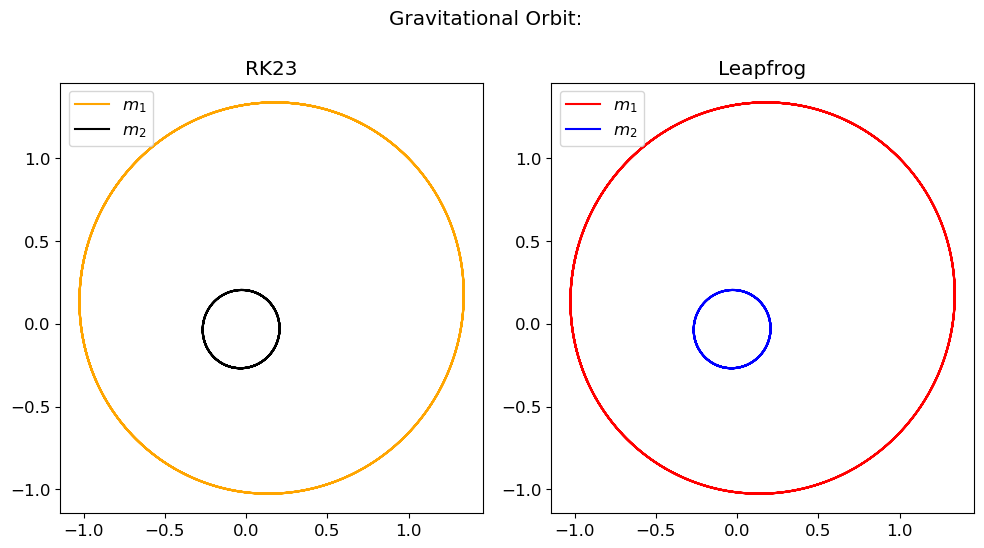

In [8]:
# Establishing initial conditions. 

x_1_0, x_1_dot_0 = 1., -1.
y_1_0, y_1_dot_0 = 1., 1.
x_2_0, x_2_dot_0 = -m_rat * x_1_0, -m_rat * x_1_dot_0
y_2_0, y_2_dot_0 = -m_rat * y_1_0, -m_rat * y_1_dot_0

q_0 = [x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, \
       x_2_0, x_2_dot_0, y_2_0, y_2_dot_0]

x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot = o1.solve_ode(t_pts, q_0)

x_1lf, x_1_dotlf, y_1lf, y_1_dotlf, x_2lf, x_2_dotlf, y_2lf, y_2_dotlf = \
                    o1.solve_ode_Leapfrog(t_pts, q_0)


# Plotting
fig = plt.figure(figsize=(10,10))
overall_title = 'Gravitational Orbit:  '
fig.suptitle(overall_title, va='baseline')
    
# Orbit Plot
ax_a = fig.add_subplot(2,2,1)                  

ax_a.plot(x_1, y_1, color='orange', label=r'$m_1$')
ax_a.plot(x_2, y_2, color='black', label=r'$m_2$') 
ax_a.set_title('RK23')

plt.legend(loc='best')

ax_b = fig.add_subplot(2,2,2)

ax_b.plot(x_1lf, y_1lf, color='red', label=r'$m_1$')
ax_b.plot(x_2lf, y_2lf, color='blue', label=r'$m_2$')
ax_b.set_title('Leapfrog')

plt.legend(loc='best')
fig.tight_layout()

## Reduction to One-Body Problem 

The problem can be reduced to a single body problem when one of the particles is taken to be very heavy and if the reference frame is stationary at that particle.  

The CM of the two body system is given by the following:

$\begin{align}
\mathbf{R} = \frac{ m_1 \mathbf{r}_1 + m_2 \mathbf{r}_2} {m_1 +m_2}
\end{align}$

Due to the conservation of momentum, we know

$\begin{align}
\mathbf{\dot R} = \text{Constant} = \frac{ m_1 \mathbf{\dot r}_1 + m_2 \mathbf{\dot r}_2} {m_1 +m_2}
\end{align}$

We can choose a reference frame such that the CM is stationary and at the origin. That would be the CM frame. 

Using the CM equations above, we have:

$\begin{align}
0 = \frac{ m_1 \mathbf{r}_1 + m_2 \mathbf{r}_2} {m_1 +m_2}
\end{align}$


$\begin{align}
0 = \frac{ m_1 \mathbf{\dot r}_1 + m_2 \mathbf{\dot r}_2} {m_1 +m_2}
\end{align}$

Rearranging for each position vector, we have:

$\begin{align}
\mathbf{r}_1 = - \frac {m_2} {m_1}  \mathbf{r}_2
\end{align}$


$\begin{align}
\mathbf{\dot r}_1 = -\frac {m_2} {m_1} \mathbf{\dot r}_2
\end{align}$

When one of the masses becomes extremely large, the CM is close to that particle and the particle acts like a fixed force center. In this limit, the problem reduces to one involving a single particle orbiting the heavier particle.

We will set up initial conditions such that one of the particles is heavy relative to the other particle. The CM velocity will be arranged so that it is zero regardless of what the initial velocity or position of either particle is.


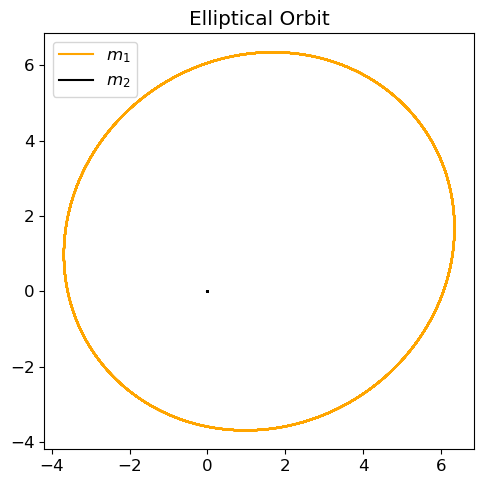

In [9]:
G = 5.
M_1 = 1.
M_2 = 1000. # Making one mass very heavy

o2 = Orbit(M_1, M_2, G)

x_1_0, x_1_dot_0 = 5., 15.
y_1_0, y_1_dot_0 = 5., -15.
x_2_0, x_2_dot_0 = -(M_1 / M_2) * x_1_0, -(M_1 / M_2) * x_1_dot_0 # Particle 2 is nearly stationary and at the origin. 
y_2_0, y_2_dot_0 = -(M_1 / M_2) * y_1_0, -(M_1 / M_2) * y_1_dot_0 

q_0 = [x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, \
       x_2_0, x_2_dot_0, y_2_0, y_2_dot_0]

x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot = o2.solve_ode(t_pts, q_0)

x_1lf, x_1_dotlf, y_1lf, y_1_dotlf, x_2lf, x_2_dotlf, y_2lf, y_2_dotlf = \
                    o2.solve_ode_Leapfrog(t_pts, q_0)


# Plotting
fig = plt.figure(figsize=(5,5))
    
# Orbit Plot
ax_a = fig.add_subplot(1,1,1)                  

ax_a.plot(x_1, y_1, color='orange', label=r'$m_1$')
ax_a.plot(x_2, y_2, color='black', label=r'$m_2$') 
ax_a.set_title('Elliptical Orbit')

plt.legend(loc='best')

fig.tight_layout()

## Energy Conservation: Leapfrog and RK23

In [10]:
x_1_0, x_1_dot_0 = 1., -1.
y_1_0, y_1_dot_0 = 1., 1.
x_2_0, x_2_dot_0 = -m_rat * x_1_0, -m_rat * x_1_dot_0
y_2_0, y_2_dot_0 = -m_rat * y_1_0, -m_rat * y_1_dot_0

q_0 = [x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, \
       x_2_0, x_2_dot_0, y_2_0, y_2_dot_0]

x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot = o1.solve_ode(t_pts, q_0)

x_1lf, x_1_dotlf, y_1lf, y_1_dotlf, x_2lf, x_2_dotlf, y_2lf, y_2_dotlf = \
                    o1.solve_ode_Leapfrog(t_pts, q_0)

E_tot_pts = o1.energy(t_pts, x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot)
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)

E_tot_pts_LF = o1.energy(t_pts, x_1lf, x_1_dotlf, \
                         y_1lf, y_1_dotlf, x_2lf, x_2_dotlf, y_2lf, y_2_dotlf)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)


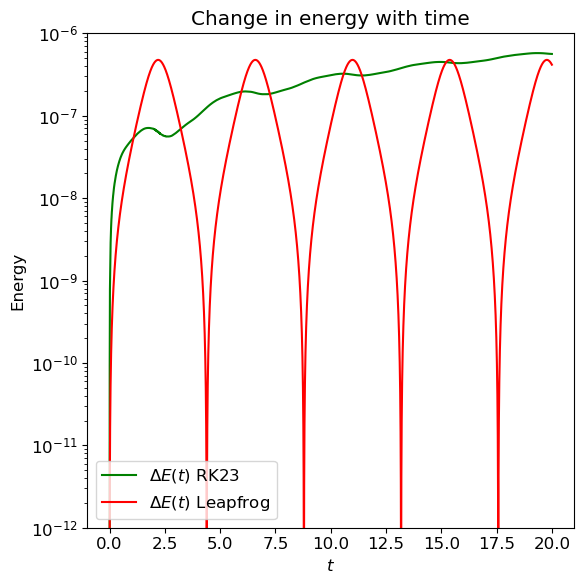

In [11]:
fig_1 = plt.figure(figsize=(6,6))

ax_c = fig_1.add_subplot(1,1,1)
ax_c.semilogy(t_pts, E_tot_rel_pts, 
               color='green', label=r'$\Delta E(t)$ RK23')
ax_c.semilogy(t_pts, E_tot_rel_pts_LF, 
               color='red', label=r'$\Delta E(t)$ Leapfrog')

ax_c.set_ylim(1.e-12, 1.e-6)  
ax_c.set_xlabel(r'$t$')
ax_c.set_ylabel(r'Energy')
ax_c.set_title('Change in energy with time')
ax_c.legend()

fig_1.tight_layout()